In [1]:
import torch
import numpy as np


import util, tr_util
from Dimploma import old_gcn
from my_gcn import GCN
from Dimploma.ppo_parallel_custom import test_random
from Dimploma.utils.graph_provider import GraphProvider

In [2]:
%load_ext autoreload
%autoreload 2

In [8]:
default_path = 'results/min_tree_ppo/node/'
# agent_path = '250220_15#n10_e36_pos3'
agent_path = '250304_17#n10_e36_pos_c6-2'
testing_path = f'{default_path}{agent_path}'

In [9]:
tr_util.load_desc(testing_path)


Added positions to nodes and calculated the distance between them
Fixed the graph generation with positions
trying out training with:
fixed graph
6-2GAT layers
with catenation between layers
1000 iterations
without early stopping

Parameters:
Gamma: 0.99
Epsilon: 0.3
Coef_value: 0.5
Coef_Entropy: 0.001
Gae_lambda: 0.95
Learning rate: 0.00025



In [13]:
node_amount = 10
max_edge_amount = torch.sum(torch.arange(node_amount)).item()
edge_amount = int(max_edge_amount*0.8)
node_features = 2  # (index, {0,1} selected or not)
iteration_amount = 1000
position = True
if position:
    node_features += 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cat_in_net = True
conv_layers = 6
conv_p_layers = 2
linear_layers = 2

graph_provider = GraphProvider(fixed_graph=None, device=device, nodes=node_amount, edges=edge_amount, position=position)


In [12]:
node_features

4

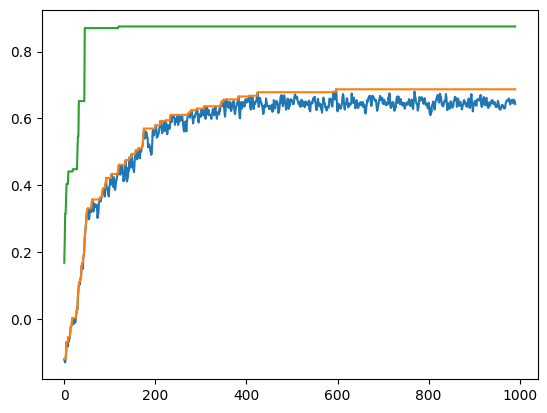

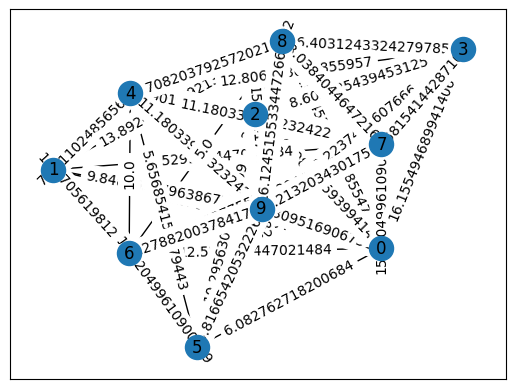

Loading model from results/min_tree_ppo/node/250304_17#n10_e36_pos_c6-2/models/iter_999_last.pt


In [14]:
loaded_graph, test_env, agent_test = tr_util.load_agent_for_testing(testing_path, iteration_amount, graph_provider, GCN(node_amount, node_features, cat_in_net, conv_layers, conv_p_layers, linear_layers), device)

In [7]:
# Testing
test_amount = 100
objs_test = np.zeros(test_amount, dtype=np.float32)
rews_test = np.zeros(test_amount, dtype=np.float32)
actions_test = np.zeros((test_amount, node_amount * 2), dtype=np.int16)

objs_test_r = np.zeros(test_amount, dtype=np.float32)
rews_test_r = np.zeros(test_amount, dtype=np.float32)
actions_test_r = np.zeros((test_amount, node_amount * 2), dtype=np.int16)

for i in range(test_amount):
    obj, sel, rew, acts = agent_test.test(test_env)
    objs_test[i] = obj
    rews_test[i] = rew[-1]
    actions_test[i, :len(acts)] = acts
    
    obj_r, sel_r, rew_r, acts_r  = test_random(test_env)
    objs_test_r[i] = obj_r
    rews_test_r[i] = rew_r[-1]
    actions_test_r[i, :len(acts_r)] = acts_r
    # print(sel)

print("Objs")
print(f'Mean: {objs_test.mean():.2f}')
print(f'Min: {objs_test.min()}')
print(f'Max: {objs_test.max()}')
print("Random")
print(f'Mean: {objs_test_r.mean():.2f}')
print(f'Min: {objs_test_r.min()}')
print(f'Max: {objs_test_r.max()}')

Objs
Mean: 89.58
Min: 46.857608795166016
Max: 138.29139709472656
Random
Mean: 92.74
Min: 47.978607177734375
Max: 143.31480407714844


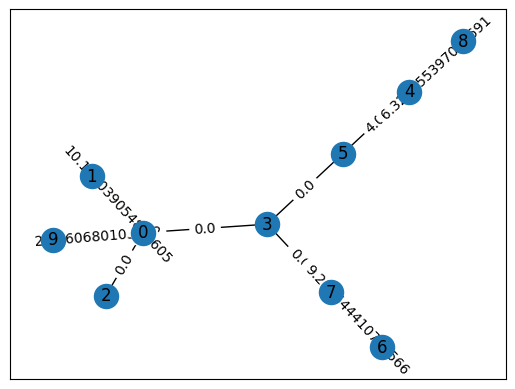

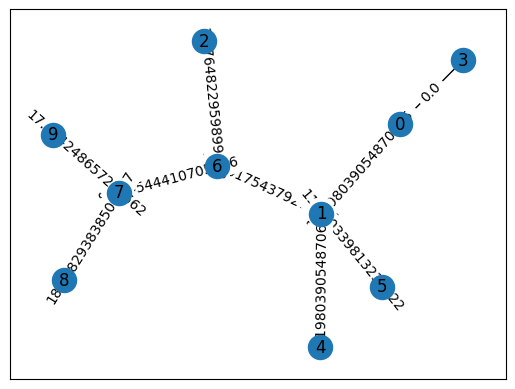

(tensor([0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
         1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.]),
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1.2276692001987382],
 [8, 7, 2, 6, 1, 0, 7, 6, 9, 7, 1, 6, 1, 4, 0, 3, 1, 5])

In [8]:
_ ,a, b, c = agent_test.test(test_env)
util.show_data(test_env.min_tree)
test_env.show_selected_tree()

# mask = torch.argwhere(graph_test.edge_attr[:, 1] == 1)[:, 0]
# sel_graph = Data(x=graph_test.x, edge_index=graph_test.edge_index[:, mask], edge_weight=graph_test.edge_weight[mask])
# sel_graph_g = util.my_to_networkx(sel_graph)
# util.show_data(sel_graph)
a,b,c

In [9]:
torch.cat([util.get_node_sums(loaded_graph).T, util.get_out_edges(loaded_graph).T], dim=1).T

tensor([[7.0000, 9.0000, 4.0000, 8.0000, 5.0000, 1.0000, 0.0000, 6.0000, 3.0000,
         2.0000],
        [1.0717, 1.6083, 1.9758, 2.3628, 3.2819, 3.2878, 3.7325, 3.7541, 4.0696,
         4.3152]])

In [19]:
torch.cat([loaded_graph.edge_index.T, loaded_graph.edge_attr], dim=1)

tensor([[ 0.0000,  5.0000,  0.6695,  0.0000, 10.8167],
        [ 0.0000,  2.0000,  0.5872,  0.0000,  9.4868],
        [ 5.0000,  8.0000,  0.3915,  0.0000,  6.3246],
        [ 2.0000,  9.0000,  0.7454,  0.0000, 12.0416],
        [ 0.0000,  3.0000,  0.8047,  0.0000, 13.0000],
        [ 2.0000,  6.0000,  0.0875,  0.0000,  1.4142],
        [ 6.0000,  1.0000,  0.8797,  0.0000, 14.2127],
        [ 0.0000,  4.0000,  0.1384,  0.0000,  2.2361],
        [ 1.0000,  7.0000,  0.1857,  0.0000,  3.0000],
        [ 4.0000,  7.0000,  0.6128,  0.0000,  9.8995],
        [ 6.0000,  4.0000,  0.0875,  0.0000,  1.4142],
        [ 8.0000,  1.0000,  0.6920,  0.0000, 11.1803],
        [ 0.0000,  9.0000,  0.1384,  0.0000,  2.2361],
        [ 5.0000,  7.0000,  0.0000,  0.0000,  0.0000],
        [ 5.0000,  9.0000,  0.0000,  0.0000,  0.0000],
        [ 3.0000,  5.0000,  0.0000,  0.0000,  0.0000],
        [ 4.0000,  8.0000,  0.0000,  0.0000,  0.0000],
        [ 4.0000,  9.0000,  0.0000,  0.0000,  0.0000],
        [ 

In [17]:
loaded_graph.x[:, 1:]

tensor([[  0.,   5.,  -2.],
        [  0.,   6.,   4.],
        [  0.,  -5.,  -1.],
        [  0., -10.,  -8.],
        [  0.,   0.,   0.],
        [  0.,   4.,   4.],
        [  0.,  -6.,  -8.],
        [  0.,  -5.,  10.],
        [  0.,  -6.,  -3.],
        [  0.,  10.,  -5.]])